<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

## *Data Science Unit 4 Sprint 3 Lesson 2*
# Convolutional Neural Networks (CNNs)

> Convolutional networks are simply neural networks that use convolution in place of general matrix multiplication in at least one of their layers. *Goodfellow, et al.*

Modern __computer vision__ approaches rely heavily on convolutions as both a dimensinoality reduction and feature extraction method. Before we dive into convolutions, let's talk about some of the common computer vision applications: 
* Classification [(Hot Dog or Not Dog)](https://www.youtube.com/watch?v=ACmydtFDTGs)
* Object Detection [(YOLO)](https://www.youtube.com/watch?v=MPU2HistivI)
* Pose Estimation [(PoseNet)](https://ai.googleblog.com/2019/08/on-device-real-time-hand-tracking-with.html)
* Facial Recognition [Emotion Detection](https://www.cbronline.com/wp-content/uploads/2018/05/Mona-lIsa-test-570x300.jpg)
* and *countless* more 

We are going to focus on pre-trained object detection today. What are some of the applications of object detection? 


## Learning Objectives
*At the end of the lecture you should be to*:
* <a href="#p1">Part 1</a>: Describe convolution and pooling
* <a href="#p2">Part 2</a>: Use a pre-trained convolutional neural network for object detection



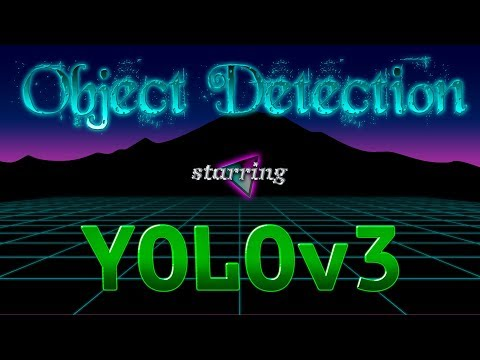

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('MPU2HistivI', width=600, height=400)

# Lecture

## Transfer Learning - TensorFlow Hub

"A library for reusable machine learning modules"

This lets you quickly take advantage of a model that was trained with thousands of GPU hours. It also enables transfer learning - reusing a part of a trained model (called a module) that includes weights and assets, but also training the overall model some yourself with your own data. The advantages are fairly clear - you can use less training data, have faster training, and have a model that generalizes better.

https://www.tensorflow.org/hub/

**WARNING** - Dragons ahead!

![Dragon](https://upload.wikimedia.org/wikipedia/commons/thumb/d/d8/Friedrich-Johann-Justin-Bertuch_Mythical-Creature-Dragon_1806.jpg/637px-Friedrich-Johann-Justin-Bertuch_Mythical-Creature-Dragon_1806.jpg)

TensorFlow Hub is very bleeding edge, and while there's a good amount of documentation out there, it's not always updated or consistent. You'll have to use your problem-solving skills if you want to use it!

In [2]:
!pip install tensorflow-hub

    100% |████████████████████████████████| 92kB 4.7MB/s ta 0:00:011
You are using pip version 10.0.1, however version 19.2.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
# TF Hub landing page example
import tensorflow as tf
import tensorflow_hub as hub

with tf.Graph().as_default():
  module_url = "https://tfhub.dev/google/nnlm-en-dim128-with-normalization/1"
  embed = hub.Module(module_url)
  embeddings = embed(["A long sentence.", "single-word",
                      "http://example.com"])

  with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.tables_initializer())

    print(sess.run(embeddings))

[[ 1.27072588e-01  1.70752838e-01 -9.90944505e-02  7.04903603e-02
   2.26204265e-02 -8.07912350e-02  1.34882599e-01  9.98359919e-02
  -9.38840210e-02  1.57970995e-01  1.49555340e-01 -7.23052993e-02
   2.82968562e-02 -7.33467517e-03  7.44888186e-02 -2.56097335e-02
   1.71663105e-01 -2.87602507e-02  5.61525524e-02  1.13487214e-01
  -1.64960790e-02 -6.53510634e-03 -2.56301146e-02 -8.42670649e-02
   8.53472874e-02 -5.40463366e-02  7.97923282e-02 -1.38562024e-01
  -1.34141564e-01 -7.57983997e-02 -9.42738429e-02 -7.67866522e-02
  -1.52945921e-01  1.80598632e-01  1.54585212e-01 -1.51075236e-02
   3.27526703e-02  9.76694282e-03 -5.50296791e-02  6.87522218e-02
  -4.60033529e-02 -6.41337559e-02  9.67478678e-02  2.06821620e-01
  -3.41980383e-02  1.59218937e-01 -1.25459984e-01  1.11098640e-01
  -8.97483621e-03  7.16845766e-02  9.47824046e-02 -1.14044234e-01
  -2.18231454e-01 -4.69759107e-03 -2.76438929e-02  2.92292908e-02
   1.41192973e-02  6.26731515e-02  3.51911001e-02 -1.73642084e-01
   8.29070

What are we getting? In this case, high quality sentence embeddings, with fairly little work. There also exist pretrained networks for images, which we will use.

## Image Similarity

Let's use a pretrained neural network to calculate image similarity. The process is similar to the image embeddings from Basilica.ai, but we'll be running the inference ourselves (though not the training - training cutting edge models can cost tens of thousands of dollars in cloud GPU hours).

First pick a module to instantiate - you can [browse modules](https://www.tensorflow.org/hub/modules/) and get fully trained state-of-the-art networks for image classification, text embeddings, and others.

Let's try [DELF](https://www.tensorflow.org/hub/modules/google/delf/1), the DEep Local Features module - it is trained on photographs of landmarks, and describes input images as "noteworthy" points of vectors. This facilitates matching two similar images (e.g. two people taking a picture of the same landmark).

In [4]:
# Step 0 - Imports
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageOps
from scipy.spatial import cKDTree
from skimage.feature import plot_matches
from skimage.measure import ransac
from skimage.transform import AffineTransform
import tensorflow as tf
import tensorflow_hub as hub

ImportError: cannot import name '_validate_lengths'

In [5]:
# Step 1 - Instantiate the module
delf_module = hub.Module("https://tfhub.dev/google/delf/1")

In [6]:
# Step 2 - Acquire images
import requests

image_urls = ["https://upload.wikimedia.org/wikipedia/commons/thumb/6/66/The_Leaning_Tower_of_Pisa_SB.jpeg/672px-The_Leaning_Tower_of_Pisa_SB.jpeg",
              "https://www.publicdomainpictures.net/pictures/120000/velka/leaning-tower-of-pisa-1427012597XXV.jpg"]

for _id,img in enumerate(image_urls): 
    r = requests.get(img)
    with open(f'tower{_id}.jpg', 'wb') as f:
        f.write(r.content)

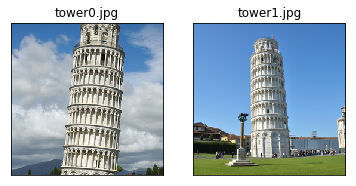

In [7]:
# Step 3 - Transform the images for DELF
IMAGE_1_JPG = 'tower0.jpg'
IMAGE_2_JPG = 'tower1.jpg'

def resize_image(filename, new_width=256, new_height=256):
  pil_image = Image.open(filename)
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
  pil_image_rgb = pil_image.convert('RGB')
  pil_image_rgb.save(filename, format='JPEG', quality=90)

resize_image(IMAGE_1_JPG)
resize_image(IMAGE_2_JPG)

def show_images(image_path_list):
  plt.figure()
  for i, image_path in enumerate(image_path_list):
    plt.subplot(1, len(image_path_list), i+1)
    plt.imshow(np.asarray(Image.open(image_path)))
    plt.title(image_path)
    plt.grid(False)
    plt.yticks([])
    plt.xticks([])
  plt.show()

show_images([IMAGE_1_JPG, IMAGE_2_JPG])

In [8]:
# Step 4 - Run DELF for each image
def image_input_fn():
  filename_queue = tf.train.string_input_producer(
      [IMAGE_1_JPG, IMAGE_2_JPG], shuffle=False)
  reader = tf.WholeFileReader()
  _, value = reader.read(filename_queue)
  image_tf = tf.image.decode_jpeg(value, channels=3)
  return tf.image.convert_image_dtype(image_tf, tf.float32)

# The module operates on a single image at a time, so define a placeholder to
# feed an arbitrary image in.
image_placeholder = tf.placeholder(
    tf.float32, shape=(None, None, 3), name='input_image')

module_inputs = {
    'image': image_placeholder,
    'score_threshold': 100.0,
    'image_scales': [0.25, 0.3536, 0.5, 0.7071, 1.0, 1.4142, 2.0],
    'max_feature_num': 1000,
}

module_outputs = delf_module(module_inputs, as_dict=True)

image_tf = image_input_fn()

with tf.train.MonitoredSession() as sess:
  results_dict = {}  # Stores the locations and their descriptors for each image
  for image_path in [IMAGE_1_JPG, IMAGE_2_JPG]:
    image = sess.run(image_tf)
    print('Extracting locations and descriptors from %s' % image_path)
    results_dict[image_path] = sess.run(
        [module_outputs['locations'], module_outputs['descriptors']],
        feed_dict={image_placeholder: image})

W0917 16:46:45.492894 140687083472704 deprecation.py:323] From <ipython-input-8-2d32bf8fd294>:4: string_input_producer (from tensorflow.python.training.input) is deprecated and will be removed in a future version.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(string_tensor).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.
W0917 16:46:45.501741 140687083472704 deprecation.py:323] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/training/input.py:278: input_producer (from tensorflow.python.training.input) is deprecated and will be removed in a future version.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(input_tensor).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`

Extracting locations and descriptors from tower0.jpg
Extracting locations and descriptors from tower1.jpg


In [9]:
# Step 5 - Use the results to match the images
def match_images(results_dict, image_1_path, image_2_path):
  distance_threshold = 0.8

  # Read features.
  locations_1, descriptors_1 = results_dict[image_1_path]
  num_features_1 = locations_1.shape[0]
  print("Loaded image 1's %d features" % num_features_1)
  locations_2, descriptors_2 = results_dict[image_2_path]
  num_features_2 = locations_2.shape[0]
  print("Loaded image 2's %d features" % num_features_2)

  # Find nearest-neighbor matches using a KD tree.
  d1_tree = cKDTree(descriptors_1)
  _, indices = d1_tree.query(
      descriptors_2, distance_upper_bound=distance_threshold)

  # Select feature locations for putative matches.
  locations_2_to_use = np.array([
      locations_2[i,]
      for i in range(num_features_2)
      if indices[i] != num_features_1
  ])
  locations_1_to_use = np.array([
      locations_1[indices[i],]
      for i in range(num_features_2)
      if indices[i] != num_features_1
  ])

  # Perform geometric verification using RANSAC.
  _, inliers = ransac(
      (locations_1_to_use, locations_2_to_use),
      AffineTransform,
      min_samples=3,
      residual_threshold=20,
      max_trials=1000)

  print('Found %d inliers' % sum(inliers))

  # Visualize correspondences.
  _, ax = plt.subplots(figsize=(9, 18))
  img_1 = mpimg.imread(image_1_path)
  img_2 = mpimg.imread(image_2_path)
  inlier_idxs = np.nonzero(inliers)[0]
  plot_matches(
      ax,
      img_1,
      img_2,
      locations_1_to_use,
      locations_2_to_use,
      np.column_stack((inlier_idxs, inlier_idxs)),
      matches_color='b')
  ax.axis('off')
  ax.set_title('DELF correspondences')

match_images(results_dict, IMAGE_1_JPG, IMAGE_2_JPG)

Loaded image 1's 247 features
Loaded image 2's 189 features


NameError: name 'ransac' is not defined

This lets us visualize a little bit better what it means to e.g. calculate the "embeddings" of an image, and then compare the values to embeddings of another image in order to calculate similarity.

## Convolutional Neural Networks

Like neural networks themselves, CNNs are inspired by biology - specifically, the receptive fields of the visual cortex.

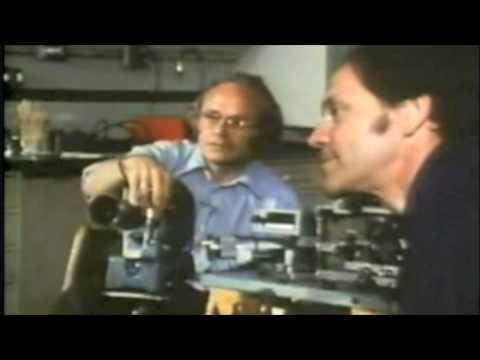

In [10]:
from IPython.display import YouTubeVideo
YouTubeVideo('IOHayh06LJ4', width=600, height=400)

Put roughly, in a real brain the neurons in the visual cortex *specialize* to be receptive to certain regions, shapes, colors, orientations, and other common visual features. In a sense, the very structure of our cognitive system transforms raw visual input, and sends it to neurons that specialize in handling particular subsets of it.

CNNs imitate this approach by applying a convolution. A convolution is an operation on two functions that produces a third function, showing how one function modifies another. Convolutions have a [variety of nice mathematical properties](https://en.wikipedia.org/wiki/Convolution#Properties) - commutativity, associativity, distributivity, and more. Applying a convolution effectively transforms the "shape" of the input.

One common confusion - the term "convolution" is used to refer to both the process of computing the third (joint) function and the process of applying it. In our context, it's more useful to think of it as an application, again loosely analogous to the mapping from visual field to receptive areas of the cortex in a real animal.

### Convolution - an example

Consider blurring an image - assume the image is represented as a matrix of numbers, where each number corresponds to the color value of a pixel.


In [11]:
import imageio
import matplotlib.pyplot as plt
from skimage import color, io
from skimage.exposure import rescale_intensity

austen = io.imread('https://dl.airtable.com/S1InFmIhQBypHBL0BICi_austen.jpg')
austen_grayscale = rescale_intensity(color.rgb2gray(austen))
austen_grayscale

ImportError: cannot import name '_validate_lengths'

In [12]:
austen_grayscale.shape

NameError: name 'austen_grayscale' is not defined

In [13]:
plt.imshow(austen_grayscale, cmap="gray");

NameError: name 'austen_grayscale' is not defined

One way to blur would be to replace each point with the average of itself and its neighbors.

In [ ]:
austen_blur1 = austen_grayscale.copy()

for i, row in enumerate(austen_grayscale):
  for j, col in enumerate(row):
    # Bit of logic to handle edges - only doing direct non-diag neighbors
    blur_val = col
    num_averaged = 1
    if i > 0:
      blur_val += austen_grayscale[i - 1][j]
      num_averaged += 1
    if j > 0:
      blur_val += austen_grayscale[i][j - 1]
      num_averaged += 1
    if i < len(austen_grayscale) - 1:
      blur_val += austen_grayscale[i + 1][j]
      num_averaged += 1
    if j < len(row) - 1:
      blur_val += austen_grayscale[i][j + 1]
      num_averaged += 1
    austen_blur1[i][j] = blur_val / num_averaged

austen_blur1

In [ ]:
plt.imshow(austen_blur1, cmap="gray");

What if we wanted to blur by averaging a larger neighborhood of pixels, but treating the closer neighbors as more important than the far ones?

One natural approach would be to use a two dimensional Normal distribution to determine the appropriate pixel weights for averaging.

In [ ]:
from skimage.filters import gaussian

# Using relatively large sigma so the filter impact is clear
austen_blur2 = gaussian(austen_grayscale, sigma=5)
austen_blur2

In [ ]:
plt.imshow(austen_blur2, cmap="gray")

This is called a *Gaussian blur*, and is an early and well-established application of convolutions.

![Gaussian blur applied to newspaper image](https://upload.wikimedia.org/wikipedia/commons/d/d7/Halftone%2C_Gaussian_Blur.jpg)

Also - it is a **convolution**!

Specifically, it's the application of the two dimensional Gaussian function to the function that is the image itself (something that takes values $x, y$ and returns a number for the value of that pixel).

And that's really it - there are of course many more convolutions out there. Following is a relatively simple form of edge detection as a convolution:

In [ ]:
import scipy.ndimage as nd

edge_convolution = np.array([[1,1,1,1,1],
                             [0,0,0,0,0],
                             [0,0,0,0,0],
                             [0,0,0,0,0],
                             [-1,-1,-1,-1,-1]])

austen_edges = nd.convolve(austen_grayscale, edge_convolution)
austen_edges

In [ ]:
plt.imshow(austen_edges, cmap="gray");

## A Typical CNN

![A Typical CNN](https://upload.wikimedia.org/wikipedia/commons/thumb/6/63/Typical_cnn.png/800px-Typical_cnn.png)

The first stage of a CNN is, unsurprisingly, a convolution - specifically, a transformation that maps regions of the input image to neurons responsible for receiving them. The convolutional layer can be visualized as follows:

![Convolutional layer](https://upload.wikimedia.org/wikipedia/commons/6/68/Conv_layer.png)

The red represents the original input image, and the blue the neurons that correspond.

As shown in the first image, a CNN can have multiple rounds of convolutions, [downsampling](https://en.wikipedia.org/wiki/Downsampling_(signal_processing)) (a digital signal processing technique that effectively reduces the information by passing through a filter), and then eventually a fully connected neural network and output layer. Typical output layers for a CNN would be oriented towards classification or detection problems - e.g. "does this picture contain a cat, a dog, or some other animal?"

Why are CNNs so popular?

1. They work, really well (see XKCD at top)
2. Compared to prior image learning techniques, they require relatively little image preprocessing (cropping/centering, normalizing, etc.)
3. Relatedly, they are *robust* to all sorts of common problems in images (shifts, lighting, etc.)

Actually training a cutting edge image classification CNN is nontrivial computationally - the good news is, with transfer learning, we can get one "off-the-shelf"!

In [14]:
import numpy as np

from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions

def process_img_path(img_path):
  return image.load_img(img_path, target_size=(224, 224))

def img_contains_banana(img):
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  model = ResNet50(weights='imagenet')
  features = model.predict(x)
  results = decode_predictions(features, top=3)[0]
  print(results)
  for entry in results:
    if entry[1] == 'banana':
      return entry[2]
  return 0.0

Using TensorFlow backend.


In [15]:
image_urls = ["https://github.com/LambdaSchool/ML-YouOnlyLookOnce/raw/master/sample_data/negative_examples/example11.jpeg",
              "https://github.com/LambdaSchool/ML-YouOnlyLookOnce/raw/master/sample_data/positive_examples/example0.jpeg"]

for _id,img in enumerate(image_urls): 
    r = requests.get(img)
    with open(f'example{_id}.jpg', 'wb') as f:
        f.write(r.content)

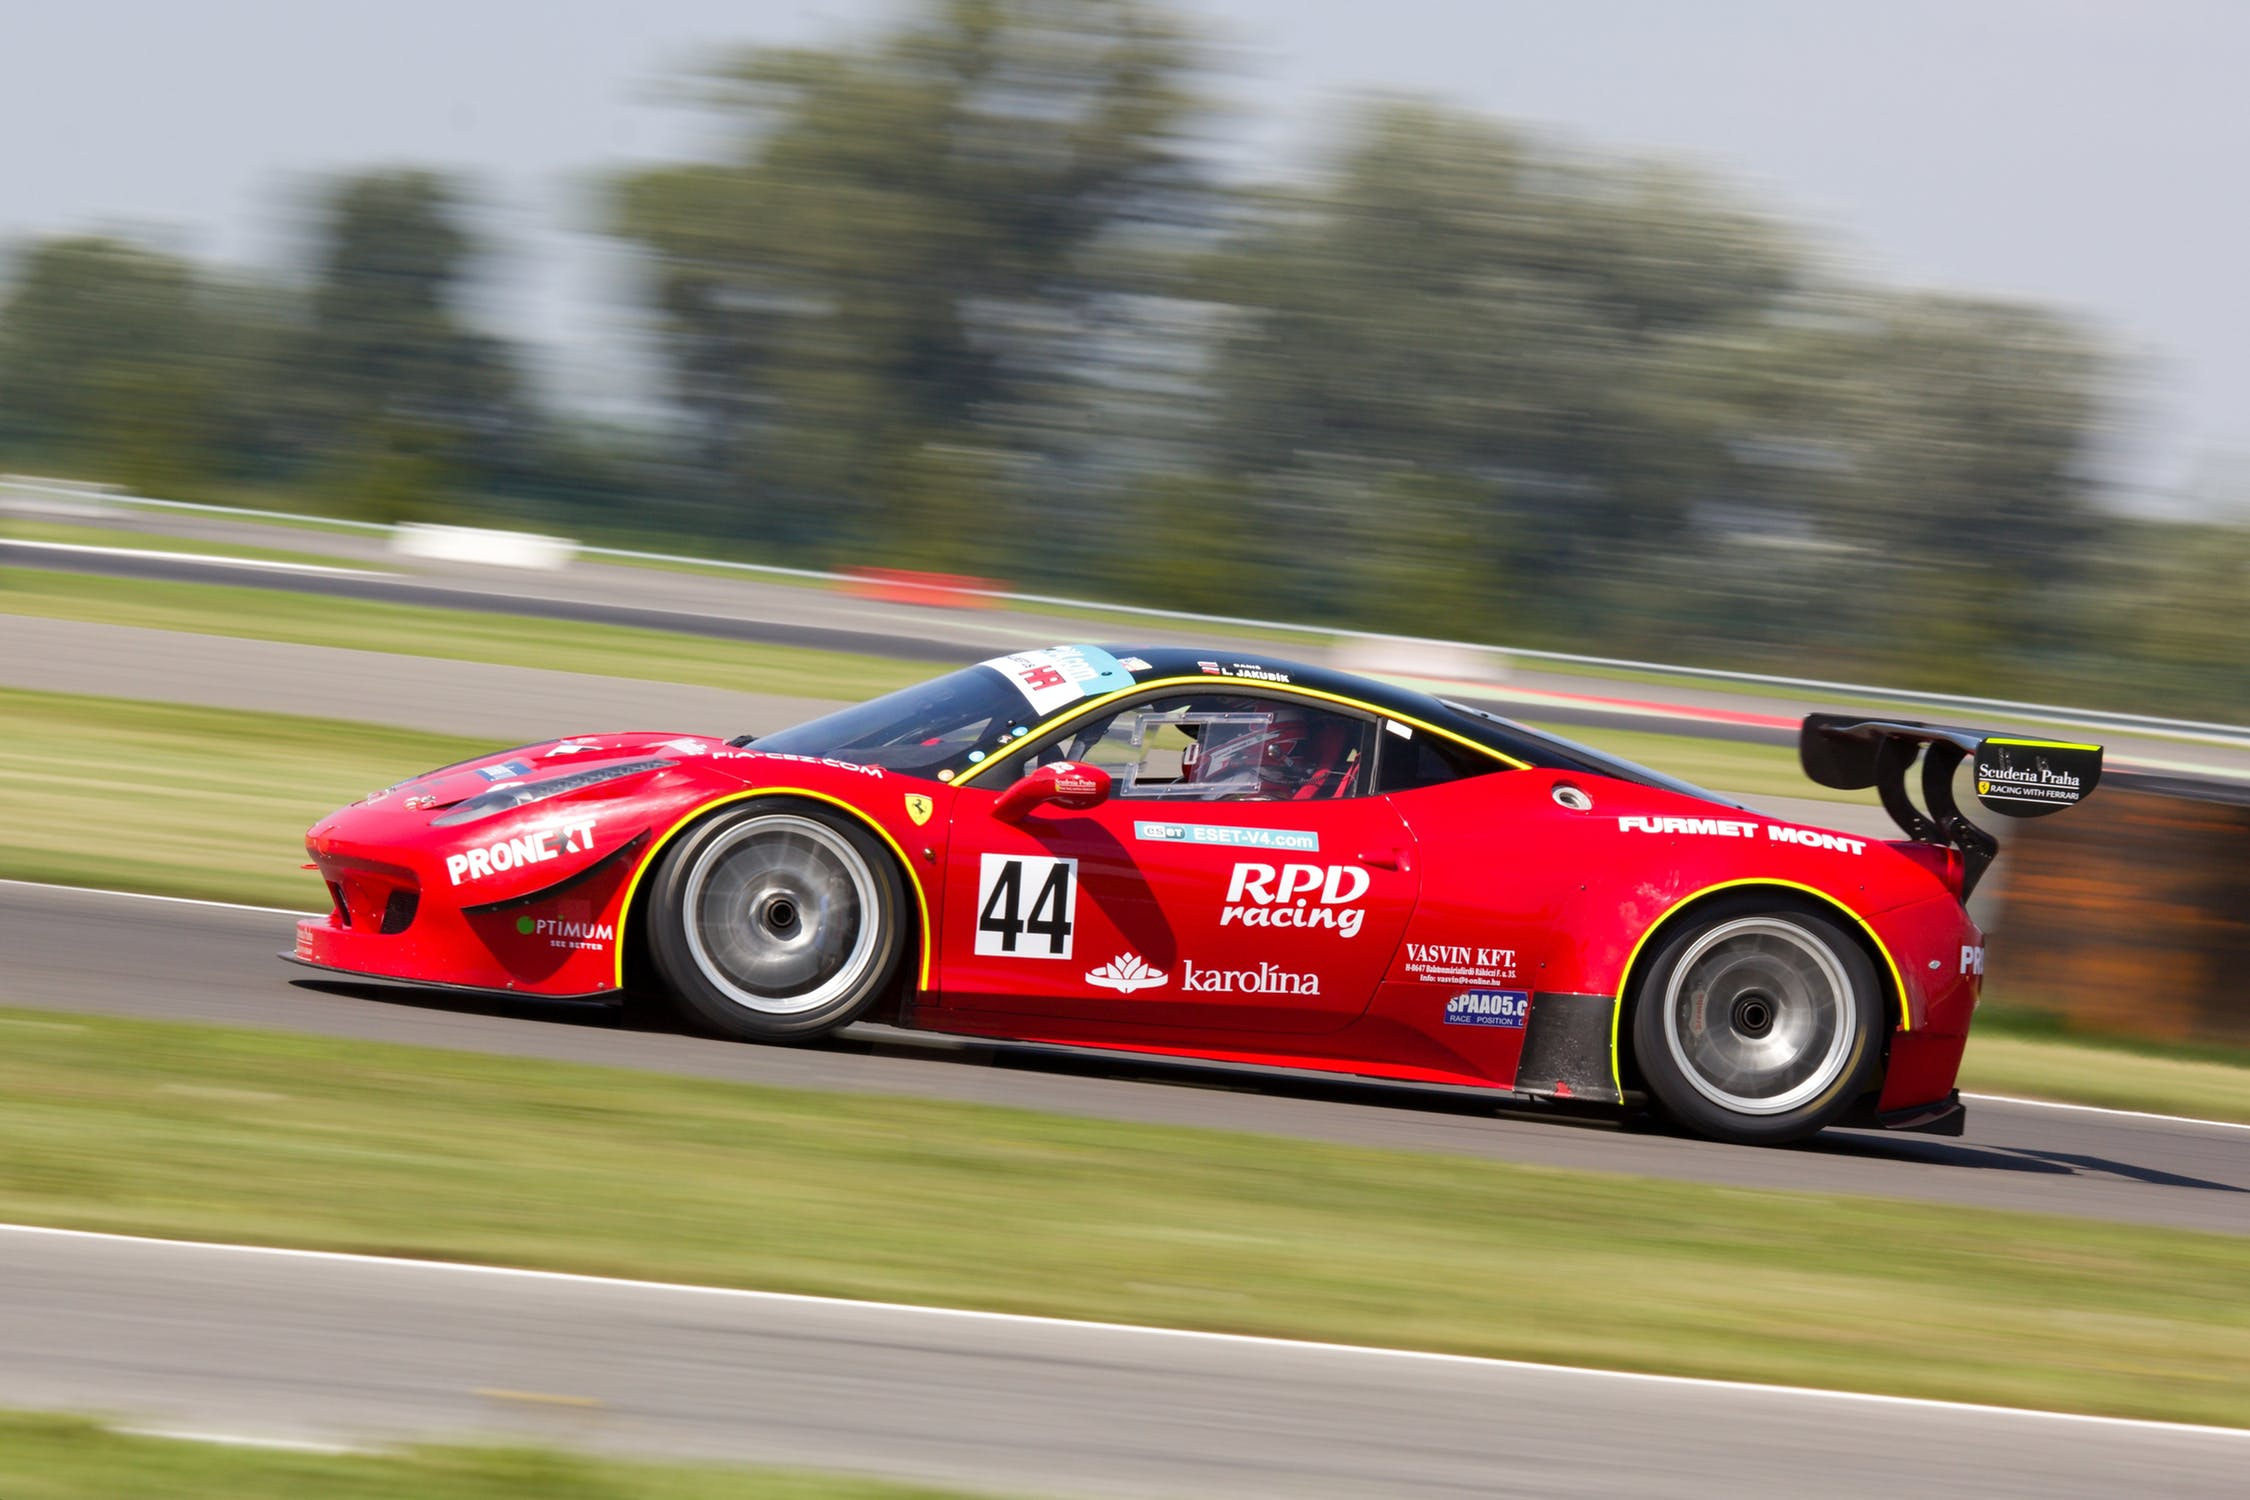

In [16]:
from IPython.display import Image
Image(filename='./example0.jpg', width=600)

In [17]:
img_contains_banana(process_img_path('example1.jpg'))

W0917 16:48:33.242998 140687083472704 deprecation_wrapper.py:119] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0917 16:48:33.243923 140687083472704 deprecation_wrapper.py:119] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0917 16:48:33.248772 140687083472704 deprecation_wrapper.py:119] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0917 16:48:33.275362 140687083472704 deprecation_wrapper.py:119] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_ba

40960/35363 [==================================] - 0s 0us/step
[('n07753592', 'banana', 0.06412259), ('n03532672', 'hook', 0.06004637), ('n03498962', 'hatchet', 0.058439817)]


0.06412259

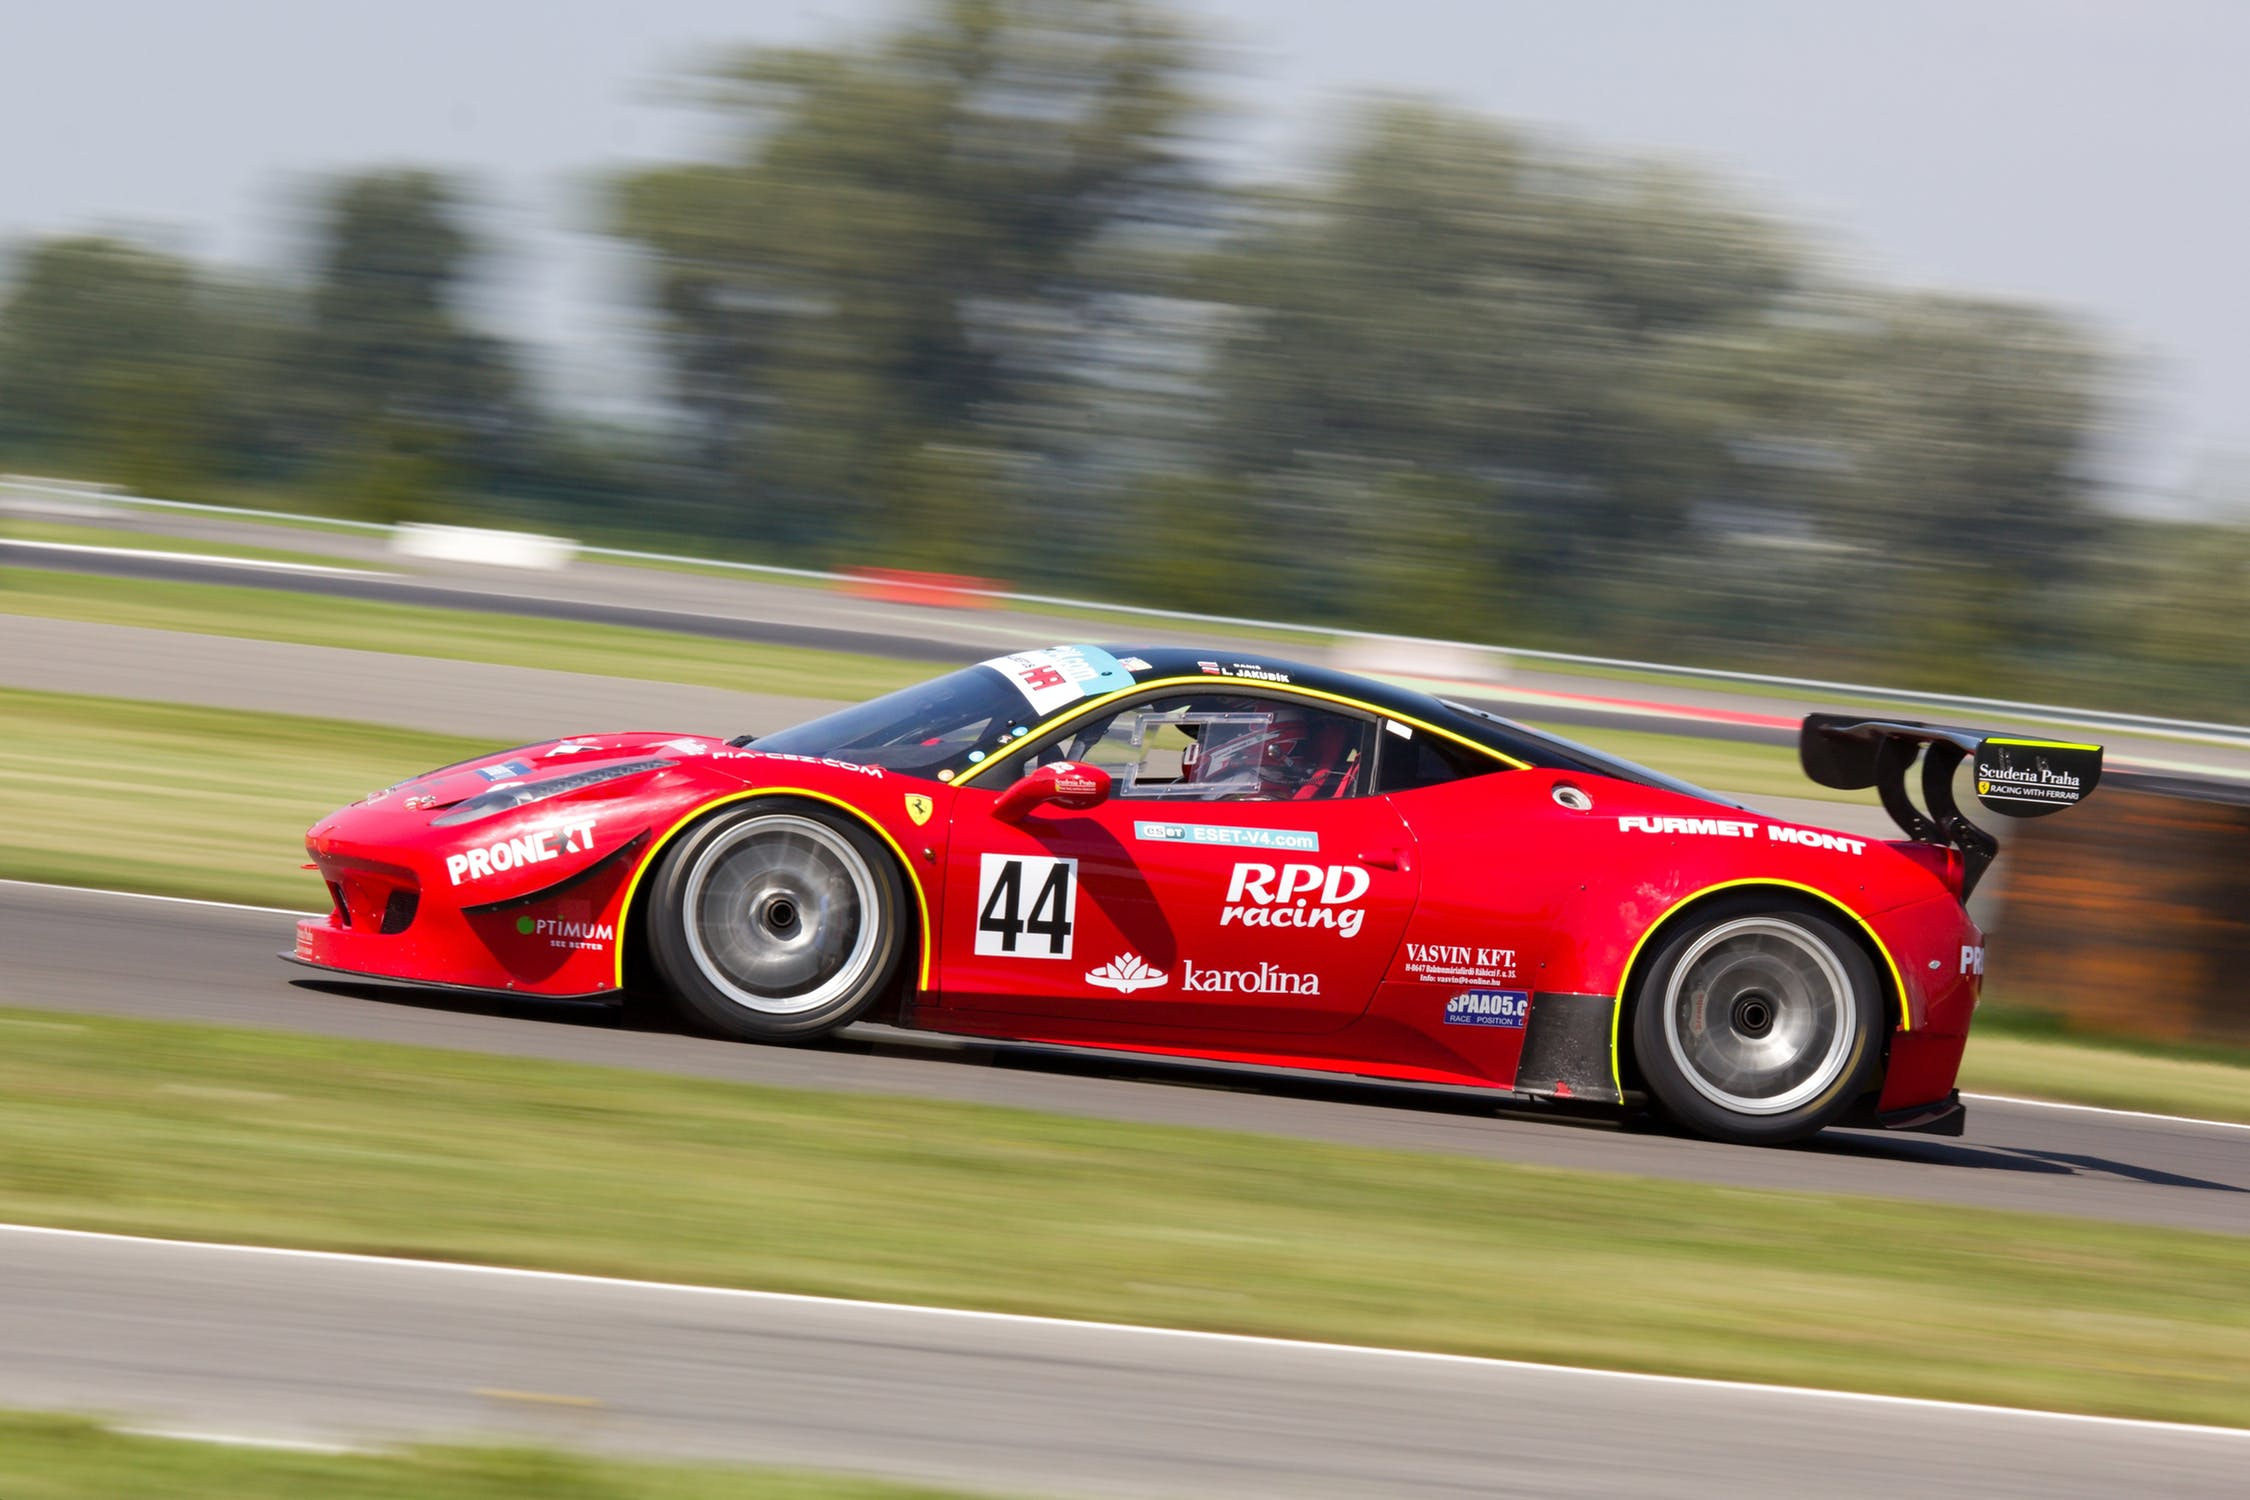

In [18]:
Image(filename='example0.jpg', width=600)

In [20]:
img_contains_banana(process_img_path('example1.jpg'))

[('n07753592', 'banana', 0.06412259), ('n03532672', 'hook', 0.06004637), ('n03498962', 'hatchet', 0.058439817)]


0.06412259

Notice that, while it gets it right, the confidence for the banana image is fairly low. That's because so much of the image is "not-banana"! How can this be improved? Bounding boxes to center on items of interest (see extended resources).

# Assignment

Load a pretrained network from TensorFlow Hub, [ResNet50](https://tfhub.dev/google/imagenet/resnet_v1_50/classification/1) - a 50 layer deep network trained to recognize [1000 objects](https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt). Starting usage:

```python
module = hub.Module("https://tfhub.dev/google/imagenet/resnet_v1_50/classification/1")
height, width = hub.get_expected_image_size(module)
images = ...  # A batch of images with shape [batch_size, height, width, 3].
logits = module(images)  # Logits with shape [batch_size, num_classes].
```

Apply it to classify the images downloaded below (images from a search for animals in national parks):

In [ ]:
!pip install google_images_download

In [ ]:
from google_images_download import google_images_download

response = google_images_download.googleimagesdownload()
arguments = {"keywords": "animal national park", "limit": 20,
             "print_urls": True}
absolute_image_paths = response.download(arguments)

In [ ]:
absolute_image_paths

Report both the most likely estimated class for any image, and also investigate (a) images where the classifier isn't that certain (the best estimate is low), and (b) images where the classifier fails.

Answer (in writing in the notebook) the following - "What sorts of images do CNN classifiers do well with? What sorts do they not do so well? And what are your hypotheses for why?"

In [ ]:
### YOUR CODE HERE